Introdução a Aprendizagem Profunda - IF867
# Exercício RNN I

### Equipe:
> Igor Domingos da Rocha e Silva (idrs)

> Lucas Nascimento Brandão (lnb)

> Matheus Isidoro Gomes Batista (migb)

In [421]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

In [422]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



# Classificação de nomes de personagens Character-Level RNN
Baseado no trabalho do **Autor**: [Sean Robertson](https://github.com/spro)

Nós estaremos desenvolvendo um modelo de Redes Neurais Recorrentes para classificação de nomes de personagens de ficção. Dado um nome estamos interessados em saber qual é o autor que aquele personagem pertençe.
Exemplo: Dado Aslam (personagem de Crônicas de Nárnia), queremos a saída: C.S. Lewis (autor de Crônicas de Nárnia)

In [423]:
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('/content/drive/MyDrive/dl/data/book/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Converter uma string Unicode em ASCII simples, graças a https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Construir o dicionário category_lines, uma lista de personagens por autor
category_lines = {}
all_categories = []

# Ler um arquivo e dividi-lo em linhas
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('/content/drive/MyDrive/dl/data/book/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['/content/drive/MyDrive/dl/data/book/Jane Austen.txt', '/content/drive/MyDrive/dl/data/book/George Orwell.txt', '/content/drive/MyDrive/dl/data/book/C.S. Lewis.txt', '/content/drive/MyDrive/dl/data/book/J.K. Rowling.txt', '/content/drive/MyDrive/dl/data/book/Agatha Christie.txt', '/content/drive/MyDrive/dl/data/book/J.R.R. Tolkien.txt', '/content/drive/MyDrive/dl/data/book/Leo Tolstoy.txt', '/content/drive/MyDrive/dl/data/book/Fiódor Dostoiévski.txt']
Slusarski


In [425]:
#lista de personagens por autor
category_lines['C.S. Lewis'][0]

'Aslan'

In [424]:
all_categories

['Jane Austen',
 'George Orwell',
 'C.S. Lewis',
 'J.K. Rowling',
 'Agatha Christie',
 'J.R.R. Tolkien',
 'Leo Tolstoy',
 'Fiódor Dostoiévski']

In [426]:
#número de autores
n_categories

contagens = []
for i in range(n_categories):
  contagens.append(len(category_lines[all_categories[i]]))


In [427]:
#contagens de nomes de personagem por autor
contagens

[83, 55, 100, 100, 63, 78, 84, 103]

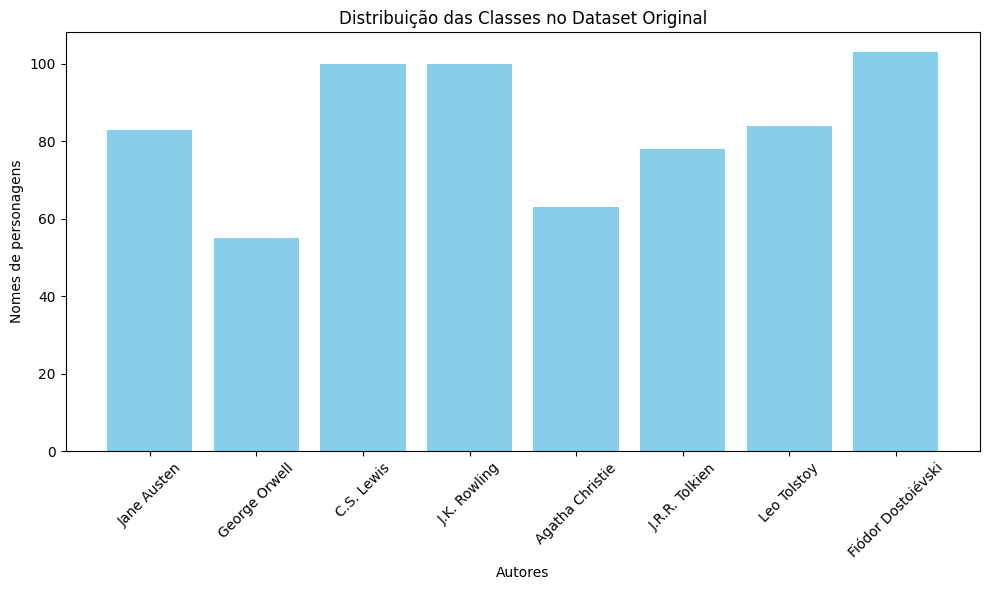

In [428]:
import matplotlib.pyplot as plt
classes = all_categories

# Cria um gráfico de barras
plt.figure(figsize=(10, 6))  # Define o tamanho do gráfico
plt.bar(classes, contagens, color='skyblue')  # Cria o gráfico de barras com os autores e personagens
plt.xlabel('Autores')  # Rótulo do eixo X
plt.ylabel('Nomes de personagens')  # Rótulo do eixo Y
plt.title('Distribuição das Classes no Dataset Original')  # Título do gráfico

# Mostra o gráfico
plt.xticks(rotation=45)  # Rotação dos rótulos das classes para melhor visualização
plt.tight_layout()  # Garante que os rótulos e barras não fiquem cortados
plt.show()


Agora temos  ``category_lines``, um dicionário que mapeia cada categoria
(autor) para uma lista de linhas (nomes). Também mantivemos o controle de
``all_categories`` (apenas uma lista de autores) e  ``n_categories`` (número de autores) para
referência posterior.




In [429]:
print(category_lines['Jane Austen'][:5])

['Elizabeth Bennet', 'Mr. Darcy ', 'Fitzwilliam Darcy', 'Mr. Bennet', 'Mrs. Bennet']


### Transformando Nomes em Tensores

Agora que temos todos os nomes organizados, precisamos convertê-los em Tensores para fazer qualquer uso deles.

Para representar uma única letra, usamos um "vetor one-hot" de tamanho
``<1 x n_letters>``. Um vetor one-hot é preenchido com 0s, exceto por um 1
no índice da letra atual, por exemplo, ``"b" = <0 1 0 0 0 ...>``.

Para formar uma palavra, juntamos um monte desses em uma matriz 2D
``<line_length x 1 x n_letters>``.

Essa dimensão extra existe porque o PyTorch assume que tudo está em
lotes - estamos apenas usando um tamanho de lote de 1 aqui.




In [430]:
len(all_letters)

57

In [431]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('E'))

print(lineToTensor('Elizabeth Bennet').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([16, 1, 57])


## Criando a Rede

Este módulo RNN (em grande parte copiado do [tutorial do PyTorch para usuários do Torch](https://pytorch.org/tutorials/beginner/former_torchies/
nn_tutorial.html#example-2-recurrent-net))
consiste apenas em 2 camadas lineares que operam em uma entrada e estado oculto, com
uma camada ``LogSoftmax`` após a saída.




In [432]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

Para executar um passo desta rede, precisamos passar uma entrada (no nosso caso, o
Tensor para a letra atual) e um estado oculto anterior (que inicializamos como zeros no início). Obteremos a saída (probabilidade de
cada idioma) e um próximo estado oculto (que manteremos para o próximo
passo).


In [433]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

In [435]:
category_lines[all_categories[0]][1]

'Mr. Darcy '

Por uma questão de eficiência, não queremos criar um novo Tensor
para cada etapa, então vamos usar  ``lineToTensor`` ao invés de
``letterToTensor``.




In [436]:
input = lineToTensor('Mr. Darcy')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.0429, -2.1144, -2.1362, -1.9784, -2.0831, -2.2079, -2.0784, -2.0126]],
       grad_fn=<LogSoftmaxBackward0>)


Como você pode ver, a saída é um Tensor ``<1 x n_categories>`` onde
cada item é a probabilidade dessa categoria (quanto maior, mais provável).



## Treinamento
Preparando para treinamento
----------------------

Antes de iniciar o treinamento, devemos criar algumas funções auxiliares. A
primeira é para interpretar a saída da rede, que sabemos ser uma
probabilidade de cada categoria. Podemos usar ``Tensor.topk`` para obter o índice
do maior valor:




In [437]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('J.K. Rowling', 3)


In [438]:

CorrectOutput = []
PredictionOutput = []
for i in range(len(all_categories)):
  #print(i)
  for j in range(len(category_lines[all_categories[i]])):
    input = lineToTensor(category_lines[all_categories[i]][j])
    CorrectOutput.append(i)
    hidden = torch.zeros(1, n_hidden)
    output, next_hidden = rnn(input[0], hidden)
    #print(output)
    autor, numberPred = categoryFromOutput(output)
    PredictionOutput.append(numberPred)
print('Correct:')
print(len(CorrectOutput))
print('Prediction:')
print(len(PredictionOutput))


Correct:
666
Prediction:
666


Também vamos querer uma maneira rápida de obter um exemplo de treinamento (um nome e seu
autor):

In [439]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)
    #print('category =', category_tensor, '/ line =', line_tensor)

category = Jane Austen / line = Fitzwilliam Darcy
category = C.S. Lewis / line = Blackbrow
category = Agatha Christie / line = Miss Emily Trefusis
category = Jane Austen / line = Maria Bertram
category = J.K. Rowling / line = Ghoul
category = Agatha Christie / line = Hildegarde Schmidt
category = George Orwell / line = Katharine
category = George Orwell / line = Rutherford
category = Agatha Christie / line = Cornelia Robson
category = George Orwell / line = Jones


### Treinando a rede

para a função de perda ``nn.NLLLoss`` é apropriada, uma vez que a última camada da RNN é ``nn.LogSoftmax``.




In [440]:
criterion = nn.NLLLoss()

Cada ciclo de treinamento fará o seguinte:

- Criar tensores de entrada e alvo.

- Criar um estado oculto inicial zerado.

- Ler cada letra e

- Manter o estado oculto para a próxima letra.

- Comparar a saída final com o alvo.

- Retropropagar o erro.

- Retornar a saída e a perda.




In [441]:
learning_rate = 0.005

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [442]:
for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    print('Output =', output, '/ loss =', loss)

Output = tensor([[-2.0113, -2.0692, -2.0848, -2.0533, -2.0704, -2.2297, -2.1127, -2.0200]],
       grad_fn=<LogSoftmaxBackward0>) / loss = 2.1126720905303955
Output = tensor([[-2.0812, -2.0799, -2.1046, -1.9910, -2.0725, -2.2331, -2.0717, -2.0190]],
       grad_fn=<LogSoftmaxBackward0>) / loss = 2.0725257396698
Output = tensor([[-2.0315, -2.1267, -2.1037, -2.0168, -2.0780, -2.1968, -2.0906, -2.0055]],
       grad_fn=<LogSoftmaxBackward0>) / loss = 2.0314531326293945
Output = tensor([[-2.0257, -2.1289, -2.1139, -2.0017, -2.0906, -2.1947, -2.0675, -2.0268]],
       grad_fn=<LogSoftmaxBackward0>) / loss = 2.0256571769714355
Output = tensor([[-2.0468, -2.0505, -2.1025, -2.0054, -2.0611, -2.2482, -2.1095, -2.0309]],
       grad_fn=<LogSoftmaxBackward0>) / loss = 2.102466583251953
Output = tensor([[-2.0566, -2.0625, -2.0800, -2.0117, -2.0687, -2.2557, -2.0965, -2.0231]],
       grad_fn=<LogSoftmaxBackward0>) / loss = 2.0565710067749023
Output = tensor([[-2.0331, -2.0926, -2.1323, -2.0276, -2

Como a função ``train`` etorna tanto a saída quanto a perda, podemos imprimir suas
suposições e também acompanhar a perda para a plotagem. Como há milhares de
exemplos, imprimimos apenas a cada ``print_every``  exemplos e fazemos uma média da perda.




In [443]:
import time
import math

n_iters = 10000
print_every = 1000
plot_every = 1000
CorrectOutput = []
PredictionOutput = []


# Acompanhar as perdas para a plotagem.
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += float(loss)

    for indice, palavra in enumerate(all_categories):
      if palavra == category:
        correct_i = indice


    guess, guess_i = categoryFromOutput(output)
    PredictionOutput.append(guess_i)
    CorrectOutput.append(correct_i)
    #print('PredictionOutput =', PredictionOutput, '/ CorrectOutput =', CorrectOutput)

    # Print ``iter`` number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        PredictionOutput.append(guess_i)
        CorrectOutput.append(correct_i)
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))
        print('PredictionOutput =', guess_i, '/ CorrectOutput =', correct_i)

    # Adicionar a média da perda atual à lista de perdas.
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

1000 10% (0m 2s) 2.0026 Maria Dmitrievna Akhrosimova / George Orwell ✗ (Leo Tolstoy)
PredictionOutput = 1 / CorrectOutput = 6
2000 20% (0m 4s) 1.9735 Rosalie Otterbourne / J.K. Rowling ✗ (Agatha Christie)
PredictionOutput = 3 / CorrectOutput = 4
3000 30% (0m 6s) 2.3999 Galadriel / Jane Austen ✗ (J.R.R. Tolkien)
PredictionOutput = 0 / CorrectOutput = 5
4000 40% (0m 9s) 1.8066 Mermaid / Leo Tolstoy ✗ (J.K. Rowling)
PredictionOutput = 6 / CorrectOutput = 3
5000 50% (0m 11s) 0.8565 Ivan Ptitsyn  / Fiódor Dostoiévski ✓
PredictionOutput = 7 / CorrectOutput = 7
6000 60% (0m 13s) 1.7775 Ginarrbrik / George Orwell ✗ (C.S. Lewis)
PredictionOutput = 1 / CorrectOutput = 2
7000 70% (0m 15s) 1.5016 Windstripe / C.S. Lewis ✓
PredictionOutput = 2 / CorrectOutput = 2
8000 80% (0m 18s) 1.6761 Tommy Beresford / J.K. Rowling ✗ (Agatha Christie)
PredictionOutput = 3 / CorrectOutput = 4
9000 90% (0m 20s) 0.4217 Prince Pyotr Pierre Kirillovich Bezukhov / Leo Tolstoy ✓
PredictionOutput = 6 / CorrectOutput =

### Plotando os resultados

Traçar a perda histórica de ``all_losses`` mostra o aprendizado da rede:


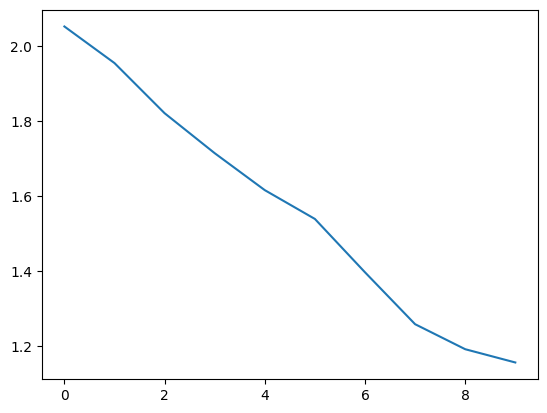

In [444]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

## Avaliando os resultados

Para ver o desempenho da rede em diferentes categorias, iremos
criar uma matriz de confusão, indicando para cada autor real (linhas)
qual autor a rede adivinha (colunas). .




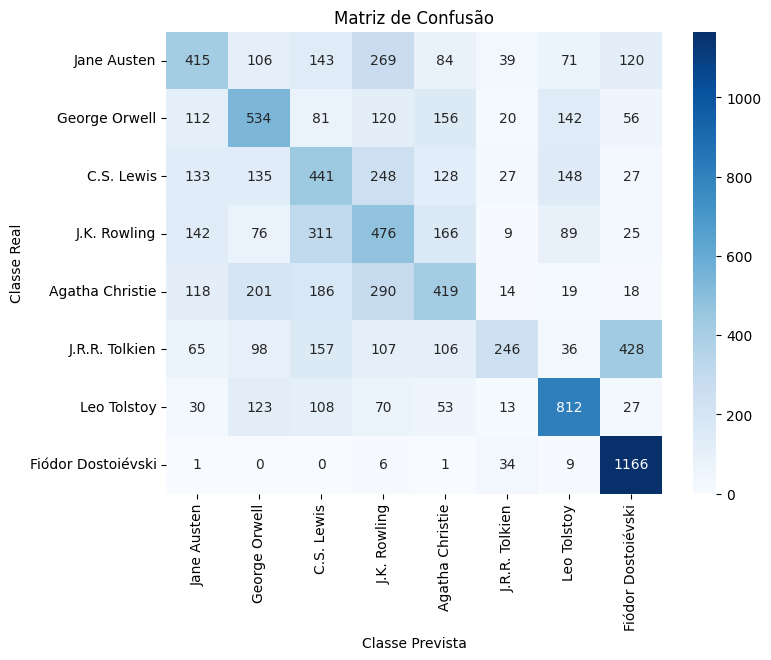

In [445]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(CorrectOutput, PredictionOutput)

classes = all_categories  # Substitua pelas suas classes

# Cria um gráfico de matriz de confusão
plt.figure(figsize=(8, 6))  # Define o tamanho do gráfico
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Classe Prevista')
plt.ylabel('Classe Real')
plt.title('Matriz de Confusão')
plt.show()

Podemos vizualizar um resultado satisfatório para os personagens criados por Dostoiévski, a razão disso pode ser as peculiaridades da língua russa, essa hipótese é reforçada quando vimos que Tolstoy também teve o mesmo resultado positivo em relação aos demais autores.

### Rodando na entrada do usuário




In [447]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Digory')
predict('Mordor')
predict('Ielena')


> Digory
(-0.80) J.K. Rowling
(-1.92) Agatha Christie
(-2.02) C.S. Lewis

> Mordor
(-1.31) J.R.R. Tolkien
(-1.45) Agatha Christie
(-1.63) George Orwell

> Ielena
(-0.61) Leo Tolstoy
(-1.34) George Orwell
(-2.66) Jane Austen
